# Introduction

Due to the COVID-19 epidemic, vaccine research and development has attracted considerable global attention. As a result, various methods for vaccine development have been tested over the past two years. 

Since vaccines serve to increase production of antigen-specific antibodies, a crucial step in vaccine development is to identify the region(s) on an antigen protein where antibodies bind – otherwise known as epitope regions. Upon recognition of such epitope regions, B-cells induce antigen-specific immune responses in vivo and produce significant quantities of antigen-specific antibodies, which inhibit the function of antigen proteins by binding to their epitope regions. 

Therefore, the automated prediction of epitope regions is extremely beneficial for developing vaccines to induce antigen-specific antibody production. It is currently one of the key research topics in vaccine development that will be widely useful for future medical data analysis. Conventional methods for epitope prediction include analysing the three-dimensional structures of antibody-antigen complexes by X-ray or nuclear magnetic resonance (NMR) spectroscopy. However, these methods incur significant time, labor and financial costs. 
On the other hand, current machine learning methods for epitope prediction focus only on the target sequence of the peptide region without considering the whole protein sequence and features. 

In this part of our project, we will combine a recurrent neural network model (RNN) with Bidirectional LSTM to predict B-cell/SARS epitopes to consider the characteristics of a whole antigen protein in addition to the target sequence.


# Data 

We used an existing dataset, which combines information extracted from both the Immune Epitope Database (IEDB), a free epitope database and prediction resource, as well as Universal Protein Resource (UniProt) – a comprehensive collection of protein sequences and their annotations. It consists of two data files – one for B-cell, and one for SARS.

The B-Cell and SARS dataset consist of an activity label which indicates – based on the number of antigen-binding sites (0 or 1) – whether a peptide exhibits antibody-inducing activity, as well as other non-class attributes: 
* Parent protein ID
* Parent protein sequence
* Start/End positions of the peptide
* Peptide sequence
* 4 Peptide features: 
  * chou_fasman, used to calculate the possibility of β turn, which helps to analyze the relative frequency of amino acid
  * emini, which is used to get relative surface accessibility that represents the surface area of a biomolecule that is enabled access to a solvent
  * Antigenicity, which refers to interaction between epitopes and antibodies or specific T cell receptors for antigens
  * Hydrophobicity refers to insolubility in water 
* 4 Protein features: 
  * the isoelectric point, which represents the pH when the molecule carries no net electrical charge
  * Aromaticity allows the electrons in the molecule to be delocalized around the ring, increasing the molecule's stability
  * Hydrophobicity
  * Stability, defined as the quality of maintaining a constant character in the presence of forces that resistance to change
  
The total number of records is 14387 for the B-cell (training) dataset and 520 for the SARS (test) dataset. Presented antibody proteins were restricted to Immunoglobulin G (IgG), the most recorded antibody type in IEDB, and records that represent different quantitative measures of antibody activity for the same peptide had been excluded for convenience. 


## Data Exploration

In [1]:
! git clone https://github.com/Ironarrow98/Bcell_data

Cloning into 'Bcell_data'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

bcell = pd.read_csv("/content/Bcell_data/input_bcell.csv")
sars = pd.read_csv("/content/Bcell_data/input_sars.csv")

In [ ]:
# create length columns
bcell["length"] = bcell["end_position"] - bcell["start_position"] + 1
sars["length"] = sars["end_position"] - sars["start_position"] + 1

feature_columns = ["chou_fasman", "emini", "kolaskar_tongaonkar", "parker", 
                   "isoelectric_point", "aromaticity", "hydrophobicity", "stability", 
                   "length"]

In [ ]:
from keras.utils.np_utils import to_categorical

bcell_peptide = bcell['peptide_seq'].to_list()
sars_peptide = sars['peptide_seq'].to_list()

n = len(max(bcell_peptide + sars_peptide, key = len))

amino_acids = ['G', 'A', 'S', 'T', 'C', 'V', 'L', 'I', 'M', 'P', 'F', 'Y', 'W', 'D', 'E', 'N', 'Q', 'H', 'K', 'R']

bcell_input_profile = np.zeros((len(bcell_peptide), n, 20, 1))

i = 0
while i < ((len(bcell_peptide))):
  pep = bcell_peptide[i]
  m = len(pep)
  for j in range(m):
    acid = pep[j]
    bcell_input_profile[i][j][amino_acids.index(acid)] = 1
  i += 1

bcell_target = to_categorical(bcell['target'], 2)

sars_input_profile = np.zeros((len(sars_peptide), n, 20, 1))

i = 0
while i < ((len(sars_peptide))):
  pep = sars_peptide[i]
  m = len(pep)
  for j in range(m):
    acid = pep[j]
    sars_input_profile[i][j][amino_acids.index(acid)] = 1
  i += 1

sars_target = to_categorical(sars['target'], 2)

## Feature Engineering

We build a model with two convolution layers, two maxpooling layer and two dense layer to extract the feature from the peptide sequence through nonlinear process. The extracted feature map from the peptide sequqnce will be combined with the original features for future classification. 

In [ ]:
import keras
from tensorflow.keras.utils import to_categorical
from keras import Model
from keras.datasets import cifar10
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Bidirectional, LSTM, Dropout, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

batch_size = 32
epochs = 100

model = Sequential()
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(n, 20, 1)))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu', name ='feature_dense'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(2, activation='sigmoid'))

# Compile the model before using it
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# create a callback that will save the best model while training
best_model = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='auto', save_best_only=True, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 391, 18, 64)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 195, 9, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 195, 9, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 193, 7, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 96, 3, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 96, 3, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0

In [ ]:
bcell_history = model.fit(bcell_input_profile, bcell_target, validation_split=0.33, 
                          callbacks=[best_model], batch_size=batch_size, epochs=epochs)

bcell_model = load_model('best_model.h5')
intermediate_layer_model = Model(inputs=bcell_model.input, outputs=bcell_model.get_layer('feature_dense').output)
intermediate_layer_model.summary()

#predict to get featured data
bcell_feauture_engg_data = intermediate_layer_model.predict(bcell_input_profile)
bcell_feauture_engg_data = pd.DataFrame(bcell_feauture_engg_data)
print('feauture_engg_data shape:', bcell_feauture_engg_data.shape)
bcell_feauture_engg_data.head(5)  #The features are unnamed now

Epoch 1/100
302/302 [==============================] - 20s 11ms/step - loss: 0.6242 - accuracy: 0.7144 - val_loss: 0.6260 - val_accuracy: 0.7481

Epoch 00001: val_loss improved from inf to 0.62600, saving model to best_model.h5
Epoch 2/100
302/302 [==============================] - 3s 9ms/step - loss: 0.5952 - accuracy: 0.7193 - val_loss: 0.6095 - val_accuracy: 0.7481

Epoch 00002: val_loss improved from 0.62600 to 0.60953, saving model to best_model.h5
Epoch 3/100
302/302 [==============================] - 3s 9ms/step - loss: 0.5837 - accuracy: 0.7193 - val_loss: 0.5995 - val_accuracy: 0.7481

Epoch 00003: val_loss improved from 0.60953 to 0.59955, saving model to best_model.h5
Epoch 4/100
302/302 [==============================] - 3s 9ms/step - loss: 0.5747 - accuracy: 0.7193 - val_loss: 0.5944 - val_accuracy: 0.7481

Epoch 00004: val_loss improved from 0.59955 to 0.59441, saving model to best_model.h5
Epoch 5/100
302/302 [==============================] - 3s 9ms/step - loss: 0.5687 

,0,1,2,3,4,5,6,7
0,0.145709,0.000000,0.268733,0.406231,0.253683,0.000000,0.286536,0.051106
1,0.099255,0.031136,0.235872,0.491710,0.003924,0.084008,0.046356,0.000000
2,0.118610,0.000000,0.254147,0.419199,0.191015,0.000000,0.242220,0.052139
3,0.000000,0.204581,0.737338,1.087266,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.106267,0.613163,0.849330,0.000000,0.000000,0.000000,0.000000


In [ ]:
sars_history = model.fit(sars_input_profile, sars_target, validation_split=0.33, 
                         callbacks=[best_model], batch_size=batch_size, epochs=epochs)

sars_model = load_model('best_model.h5')
intermediate_layer_model = Model(inputs=sars_model.input, outputs=sars_model.get_layer('feature_dense').output)
intermediate_layer_model.summary()

#predict to get featured data
sars_feauture_engg_data = intermediate_layer_model.predict(sars_input_profile)
sars_feauture_engg_data = pd.DataFrame(sars_feauture_engg_data)
print('feauture_engg_data shape:', sars_feauture_engg_data.shape)
sars_feauture_engg_data.head(5)  #The features are unnamed now

Epoch 1/100
11/11 [==============================] - 0s 23ms/step - loss: 1.0148 - accuracy: 0.6580 - val_loss: 0.6275 - val_accuracy: 0.7791

Epoch 00001: val_loss did not improve from 0.59290
Epoch 2/100
11/11 [==============================] - 0s 11ms/step - loss: 0.6324 - accuracy: 0.6868 - val_loss: 0.5772 - val_accuracy: 0.7849

Epoch 00002: val_loss improved from 0.59290 to 0.57720, saving model to best_model.h5
Epoch 3/100
11/11 [==============================] - 0s 10ms/step - loss: 0.5906 - accuracy: 0.7241 - val_loss: 0.5432 - val_accuracy: 0.8023

Epoch 00003: val_loss improved from 0.57720 to 0.54322, saving model to best_model.h5
Epoch 4/100
11/11 [==============================] - 0s 11ms/step - loss: 0.5264 - accuracy: 0.7644 - val_loss: 0.5359 - val_accuracy: 0.7965

Epoch 00004: val_loss improved from 0.54322 to 0.53589, saving model to best_model.h5
Epoch 5/100
11/11 [==============================] - 0s 11ms/step - loss: 0.5211 - accuracy: 0.7471 - val_loss: 0.5322 

,0,1,2,3,4,5,6,7
0,0.449446,0.000000,0.000000,0.000000,0.599546,0.383232,0.608127,0.573462
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.151451,0.141456,0.183192,0.000000,0.000000,0.000000,0.000000
3,0.166698,0.000000,0.000000,0.000000,0.237702,0.173821,0.329151,0.238543
4,0.443462,0.000000,0.000000,0.000000,0.601882,0.395713,0.700390,0.545708


# RNN with BLSTM

The RNN module is applied in the prediction model. However, the original RNN encounters gradient vanishing and gradient explosion problems. Therefore, we use LSTM, which is normally augmented by recurrent gates, which include input gates, output gates, and forget gates to prevent back-propagating errors from gradient vanishing and gradient explosion. 

Furthermore, to better calculate the relationship, the bidirectional LSTM (BLSTM) is used in the prediction model, which combines forward LSTM and backward LSTM to preserve the upstream and downstream information of the peptide sequence by combining the two hidden states. In this model, the RNN module analyses the training input using 64 + 20 LSTM units in both directions within two layers, over 100 epochs. 

In [ ]:
bcell_X = bcell[feature_columns].join(bcell_feauture_engg_data).to_numpy()
bcell_y = to_categorical(bcell['target'], 2)
sars_X = sars[feature_columns].join(sars_feauture_engg_data).to_numpy()
sars_y = to_categorical(sars['target'], 2)

batch_size = 64
epochs = 100

# Setting 'random_state' to 1 ensures that we get the same split each time so we can reproduce our results.
X_train, X_test, y_train, y_test = train_test_split(bcell_X, bcell_y, test_size = 0.33, random_state = 1, stratify = bcell_y)
train_X, val_X, train_y, val_y = train_test_split(X_train, y_train, test_size = 0.33, random_state = 1, stratify = y_train)

X_train = X_train.reshape(1, X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(1, X_test.shape[0], X_test.shape[1])
train_X = train_X.reshape(1, train_X.shape[0], train_X.shape[1])
val_X = val_X.reshape(1, val_X.shape[0], val_X.shape[1])

train_y = train_y.reshape(1, train_y.shape[0], train_y.shape[1])
val_y = val_y.reshape(1, val_y.shape[0], val_y.shape[1])

# Building the model
bcell_model = Sequential()
# Adding a Bidirectional LSTM layer
bcell_model.add(Bidirectional(LSTM(64, return_sequences = True, dropout = 0.5, input_shape = (9639, 17))))
bcell_model.add(Bidirectional(LSTM(20, return_sequences = True, dropout = 0.5)))
bcell_model.add(Dense(2, activation = 'sigmoid'))
bcell_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

# create a callback that will save the best model while training
bcell_best_model = ModelCheckpoint('bcell_best_model.h5', monitor = 'val_accuracy', mode = 'max', save_best_only = True, verbose = 1)

# Training the model
history1 = bcell_model.fit(train_X, train_y, batch_size = batch_size, epochs = epochs, 
                           validation_data = (val_X, val_y), shuffle = True, callbacks = [bcell_best_model])
print(bcell_model.summary())

Epoch 1/100
1/1 [==============================] - 11s 11s/step - loss: 0.6457 - accuracy: 0.7041 - val_loss: 0.6126 - val_accuracy: 0.7287

Epoch 00001: val_accuracy improved from -inf to 0.72870, saving model to bcell_best_model.h5
Epoch 2/100
1/1 [==============================] - 1s 636ms/step - loss: 0.6117 - accuracy: 0.7279 - val_loss: 0.5954 - val_accuracy: 0.7287

Epoch 00002: val_accuracy did not improve from 0.72870
Epoch 3/100
1/1 [==============================] - 1s 642ms/step - loss: 0.5952 - accuracy: 0.7289 - val_loss: 0.5874 - val_accuracy: 0.7287

Epoch 00003: val_accuracy did not improve from 0.72870
Epoch 4/100
1/1 [==============================] - 1s 652ms/step - loss: 0.5908 - accuracy: 0.7289 - val_loss: 0.5852 - val_accuracy: 0.7287

Epoch 00004: val_accuracy did not improve from 0.72870
Epoch 5/100
1/1 [==============================] - 1s 645ms/step - loss: 0.5916 - accuracy: 0.7289 - val_loss: 0.5853 - val_accuracy: 0.7287

Epoch 00005: val_accuracy did not

In [ ]:
from sklearn.metrics import f1_score, fbeta_score, precision_score, recall_score, confusion_matrix, classification_report

# Evaluate the best model saved (i.e., model with best validation accuracy) on the test set
saved_model = load_model('bcell_best_model.h5')

# evaluate the model
y_pred = saved_model.predict(X_test)
y_pred = list(np.argmax(y_pred, axis=-1))
y_pred = [item for sublist in y_pred for item in sublist]
y_test1 = np.argmax(y_test, axis=-1)
print(classification_report(y_test1, y_pred, target_names = ['0', '1']))

              precision    recall  f1-score   support

           0       0.73      1.00      0.84      3460
           1       0.00      0.00      0.00      1288

    accuracy                           0.73      4748
   macro avg       0.36      0.50      0.42      4748
weighted avg       0.53      0.73      0.61      4748



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
1/1 [==============================] - 11s 11s/step - loss: 0.7578 - accuracy: 0.3320 - val_loss: 0.7463 - val_accuracy: 0.2717

Epoch 00001: val_accuracy improved from -inf to 0.27169, saving model to sars_best_model.h5
Epoch 2/100
1/1 [==============================] - 1s 949ms/step - loss: 0.7014 - accuracy: 0.5180 - val_loss: 0.6899 - val_accuracy: 0.5181

Epoch 00002: val_accuracy improved from 0.27169 to 0.51811, saving model to sars_best_model.h5
Epoch 3/100
1/1 [==============================] - 1s 956ms/step - loss: 0.6581 - accuracy: 0.6841 - val_loss: 0.6414 - val_accuracy: 0.7287

Epoch 00003: val_accuracy improved from 0.51811 to 0.72873, saving model to sars_best_model.h5
Epoch 4/100
1/1 [==============================] - 1s 955ms/step - loss: 0.6260 - accuracy: 0.7261 - val_loss: 0.6147 - val_accuracy: 0.7287

Epoch 00004: val_accuracy did not improve from 0.72873
Epoch 5/100
1/1 [==============================] - 1s 936ms/step - loss: 0.6047 - accuracy: 0.72

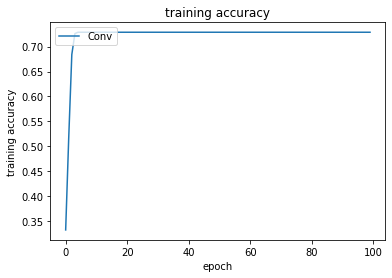

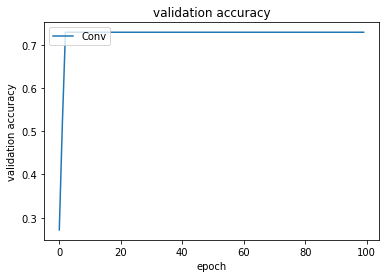

In [ ]:
y_train = y_train.reshape(1, y_train.shape[0], y_train.shape[1])
y_test = y_test.reshape(1, y_test.shape[0], y_test.shape[1])

# Building the model
sars_model = Sequential()
# Adding a Bidirectional LSTM layer
sars_model.add(Bidirectional(LSTM(64, return_sequences = True, dropout = 0.5, input_shape = (X_train.shape[0], X_train.shape[1]))))
sars_model.add(Bidirectional(LSTM(20, return_sequences = True, dropout = 0.5)))
sars_model.add(Dense(2, activation = 'sigmoid'))
sars_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

# create a callback that will save the best model while training
sars_best_model = ModelCheckpoint('sars_best_model.h5', monitor = 'val_accuracy', mode = 'max', save_best_only = True, verbose = 1)

# Training the model
history2 = sars_model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_test, y_test), shuffle = True, callbacks=[sars_best_model])
print(sars_model.summary())

# Plot training accuracy
plt.plot(history2.history['accuracy'])
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['Conv'], loc='upper left')
plt.show()

# Plot validation accuracy
plt.plot(history2.history['val_accuracy'])
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['Conv'], loc='upper left')
plt.show()



In [ ]:
X_sars  = sars_X.reshape(1, sars_X.shape[0], sars_X.shape[1])

# Evaluate the best model saved (i.e., model with best validation accuracy) on the test set
saved_model = load_model('sars_best_model.h5')

y_pred = saved_model.predict(X_sars)
y_pred = list(np.argmax(y_pred, axis=-1))
y_pred = [item for sublist in y_pred for item in sublist]
y_test2 = np.argmax(sars_y, axis=-1)
print(classification_report(y_test2, y_pred, target_names = ['0', '1']))

              precision    recall  f1-score   support

           0       0.73      1.00      0.85       380
           1       0.67      0.01      0.03       140

    accuracy                           0.73       520
   macro avg       0.70      0.51      0.44       520
weighted avg       0.72      0.73      0.63       520



# Discussion

From the result, we can see the accuracy of B-cell and SARS are the same. In B-cell, all the score of 1 are 0, we think the reason may cause by imbalance of dependent data. The 1 in B-cell is 1288 and 0 is 3460, almost three times more than 1. So, in the future we can use oversampling to solve the class imbalance. Back to SARS, the prediction on 0 and 1 are good. The macro and weighted average of precision is much better than B-cell, increased over 20% to 40%. 

Compared to Machine Learning part, the deep learning is not as good as expected. Though the recall and f1 score of 1 in machine learning is also low, RNN is only 0.01 and 0.03. we think the reason is still the imbalance of dataset.

Most of time, RNN is used for time series problem or sequential data, when the current step has relation with the previous steps. In this step, RNN is used for target analysis especially for sequence. 
